In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import pickle
import anndata as ad
from scipy.stats import norm
import os
from tqdm.notebook import tqdm
sys.path.append("../roi_analysis/")
from neighbor_graphs import NeighborEnricher
sys.path.append("../data_utils/")
from data_utils import get_high_quality_samples, get_data_csv

In [3]:
base = "/data_nfs/"
dataset = group = "Melanoma"

data = get_data_csv(base=base, dataset=dataset, group=group)
with open(os.path.join(base, "je30bery/melanoma_data/cell_type_analysis/THEORETIC/cell_coordinates.pickle"), 'rb') as handle:
    cell_coordinates = pickle.load(handle)
print(len(data))
data = data[data["file_path"].isin(list(cell_coordinates.keys()))]
print(len(data))
data = data.reset_index()

60
58


In [7]:
ne = NeighborEnricher(cell_coordinates, base)
tumor_stages = [['T1a', 'T1b'], ['T2a', 'T2b'], ['T3a', 'T3b'], ['T4b']]

dfs = dict()
for i, tumor_stage in enumerate(tumor_stages):
    data_subset = data[data["Tumor stage"].isin(tumor_stage)]
    tumor_stage = tumor_stage[0][:-1]
    cts = list()
    rois = list()
    dfs[tumor_stage] = dict()
    for fov in np.unique(data_subset["file_path"]):
        try:
            cell_types = ne.get_cell_types(fov)
            roi_cells = ne.get_roi_cells(fov)
            roi_info = np.zeros(len(cell_types))
            assert roi_cells[0] == 0
            roi_info[roi_cells[1:] - 1] = 1
            roi_info = roi_info.astype(bool)
            rois += list(roi_info)
            cts += cell_types
            res = pd.DataFrame(np.array([rois, cts]).T, columns=["In ROI", "Cell type"])
            res["Histo-ID"] = data.set_index("file_path").loc[fov]["Histo-ID"]
            dfs[tumor_stage][fov] = res
        except FileNotFoundError:
            print(fov)
            continue

In [8]:
for ts in dfs.keys():
    dfs[ts] = pd.concat(dfs[ts])

In [9]:
dfs = pd.concat(dfs).reset_index().rename({"level_0": "Tumor stage", "level_1": "Field of view"}, axis=1)

In [ ]:
#dfs = dfs.set_index("Histo-ID").drop("B033", axis=0).reset_index()

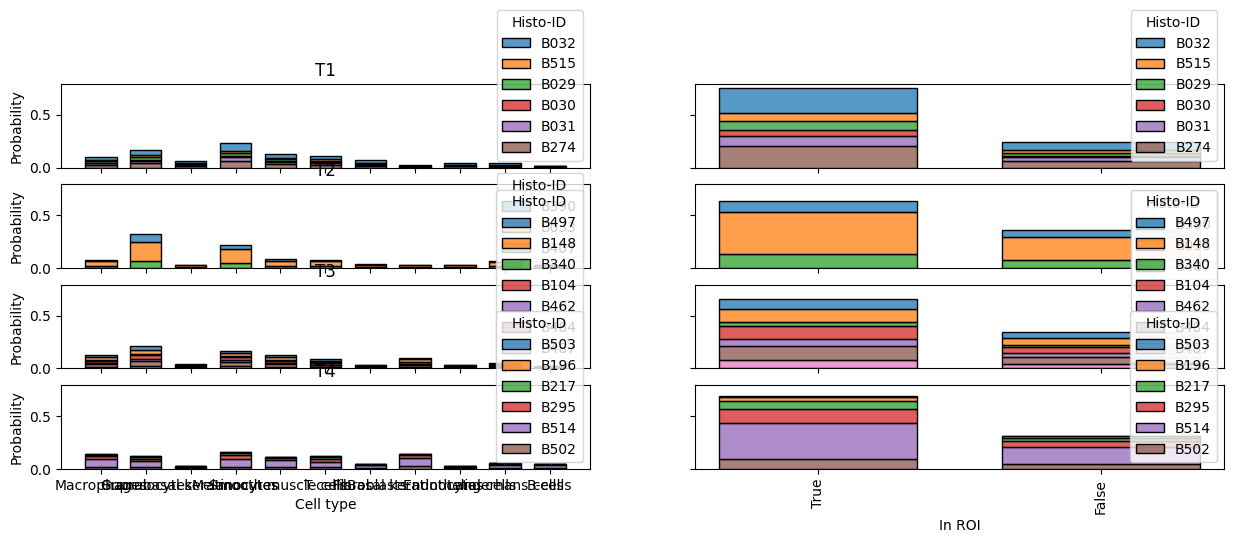

In [10]:
palette = ["#B51B1B", "#117211"]
f, axs = plt.subplots(4, 2, figsize=(15, 5), sharex="col", sharey=True)
for i, tumor_stage in enumerate(np.unique(dfs["Tumor stage"])):
    subset = dfs[dfs["Tumor stage"] == tumor_stage]
    sns.histplot(subset, x="Cell type", hue="Histo-ID", ax=axs[i, 0], shrink=0.7, stat="probability", multiple="stack")
    sns.histplot(subset, x="In ROI", hue="Histo-ID", ax=axs[i, 1], shrink=0.7, stat="probability", multiple="stack")
    axs[i, 0].set_title(tumor_stage)
plt.xticks(rotation=90)
plt.show()

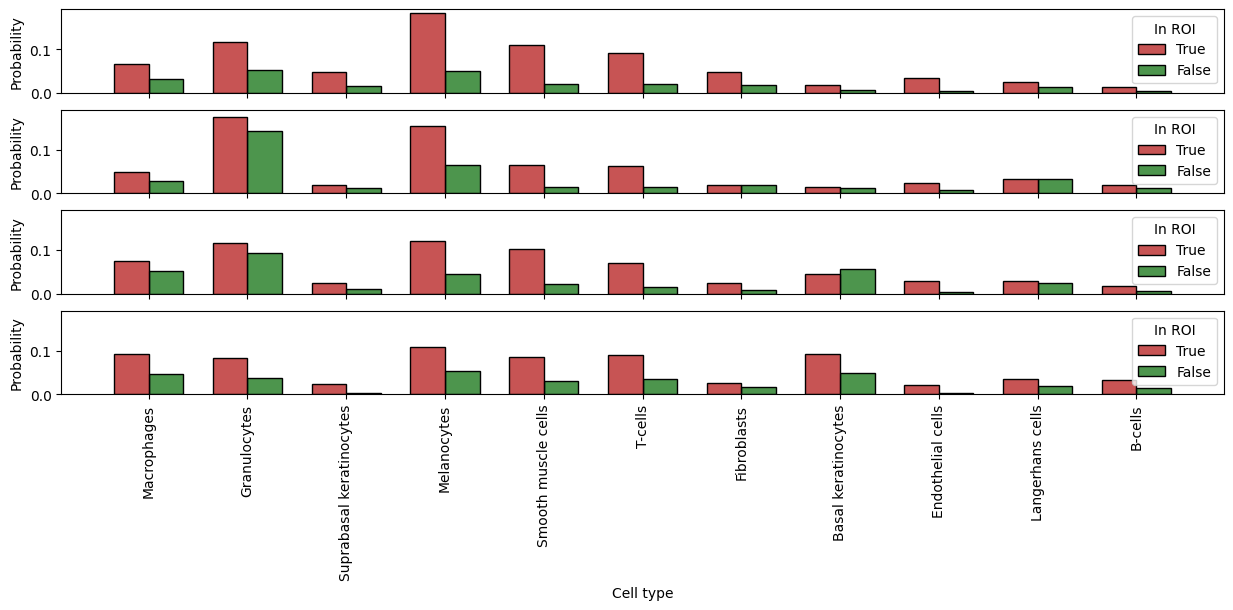

In [11]:
palette = ["#B51B1B", "#117211"]
f, axs = plt.subplots(4, 1, figsize=(15, 5), sharex=True, sharey=True)
for i, tumor_stage in enumerate(np.unique(dfs["Tumor stage"])):
    subset = dfs[dfs["Tumor stage"] == tumor_stage]
    sns.histplot(subset, x="Cell type", hue="In ROI", ax=axs[i], multiple="dodge", shrink=0.7, stat="probability", hue_order=["True", "False"], palette=palette)
plt.xticks(rotation=90) 
plt.show()

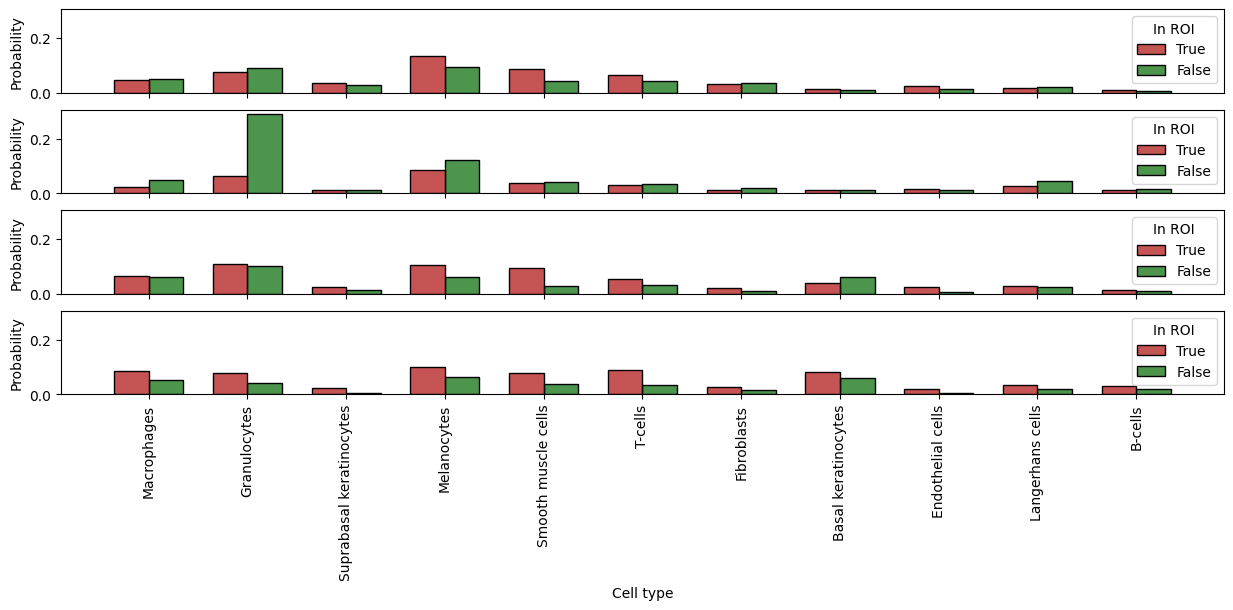

In [11]:
palette = ["#B51B1B", "#117211"]
f, axs = plt.subplots(4, 1, figsize=(15, 5), sharex=True, sharey=True)
for i, tumor_stage in enumerate(np.unique(dfs["Tumor stage"])):
    subset = dfs[dfs["Tumor stage"] == tumor_stage]
    sns.histplot(subset, x="Cell type", hue="In ROI", ax=axs[i], multiple="dodge", shrink=0.7, stat="probability", hue_order=["True", "False"], palette=palette)
plt.xticks(rotation=90) 
plt.show()

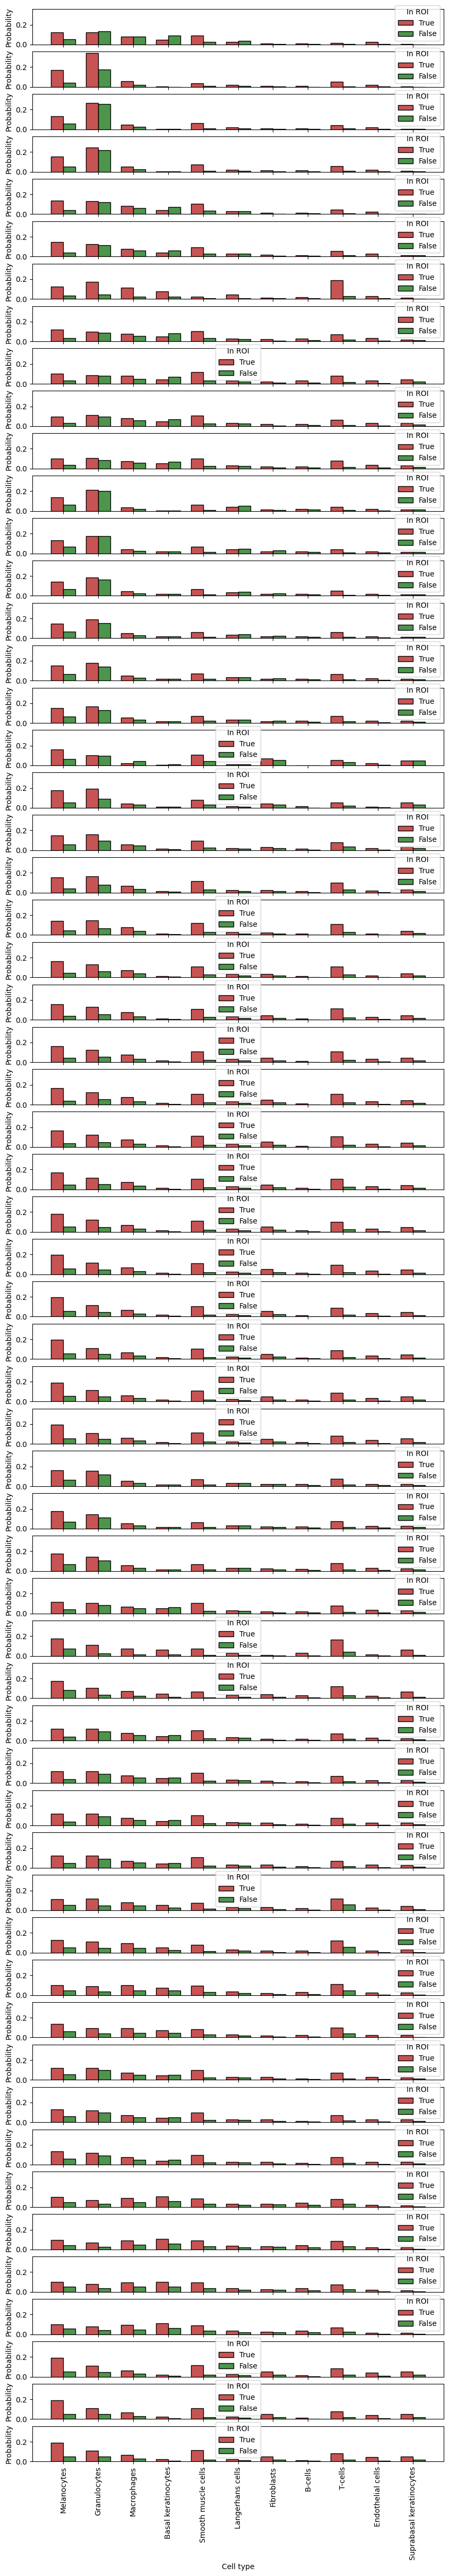

In [12]:
palette = ["#B51B1B", "#117211"]
f, axs = plt.subplots(len(np.unique(dfs["Field of view"])), 1, figsize=(10, 60), sharex=True, sharey=True)
for i, fov in enumerate(np.unique(dfs["Field of view"])):
    subset = dfs[dfs["Field of view"] == fov]
    sns.histplot(subset, x="Cell type", hue="In ROI", ax=axs[i], multiple="dodge", shrink=0.7, stat="probability", hue_order=["True", "False"], palette=palette)
plt.xticks(rotation=90)
plt.show()

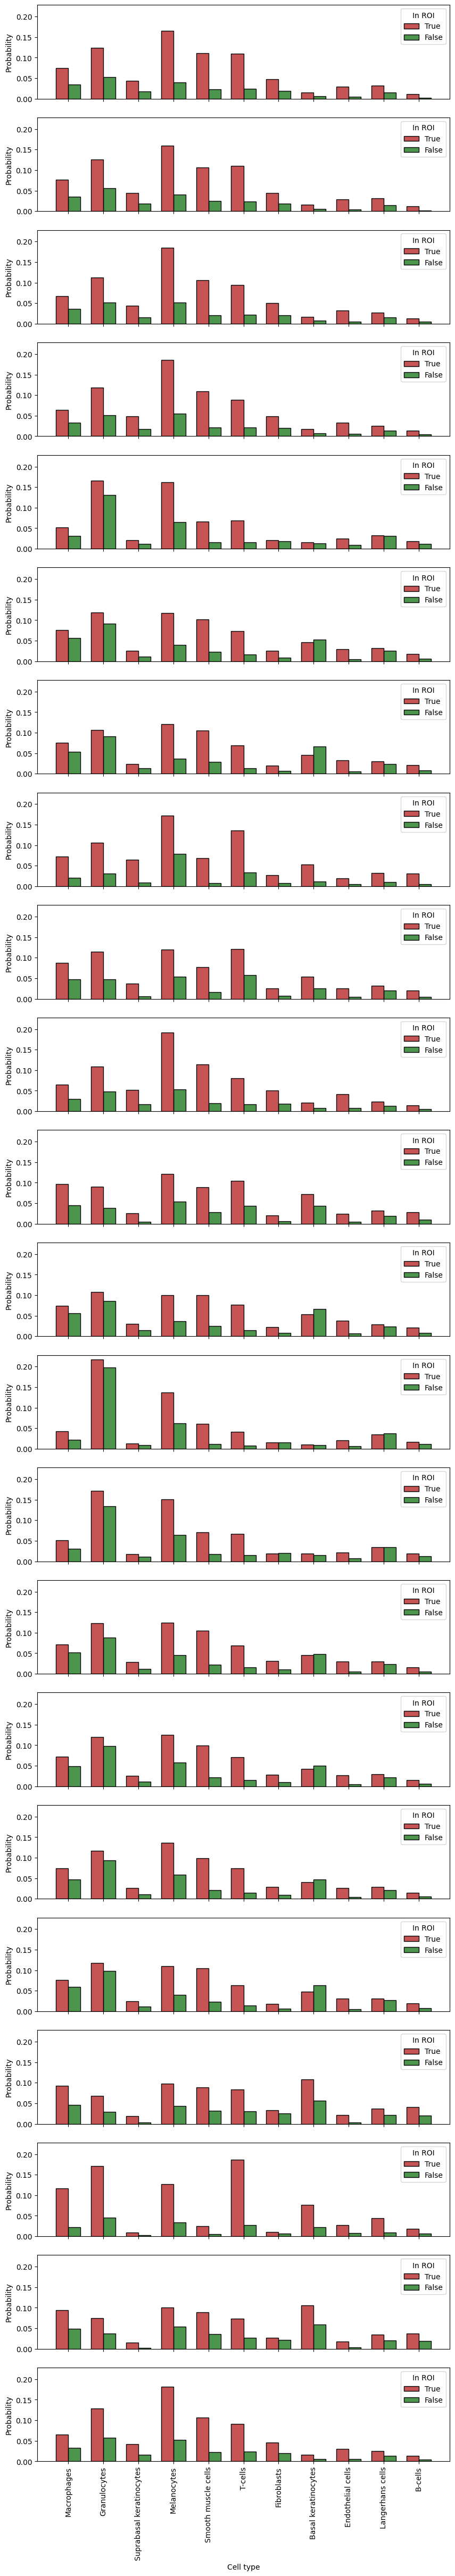

In [13]:
palette = ["#B51B1B", "#117211"]
f, axs = plt.subplots(len(np.unique(dfs["Histo-ID"])), 1, figsize=(10, 60), sharex=True, sharey=True)
for i, fov in enumerate(np.unique(dfs["Histo-ID"])):
    subset = dfs[dfs["Histo-ID"] == fov]
    sns.histplot(subset, x="Cell type", hue="In ROI", ax=axs[i], multiple="dodge", shrink=0.7, stat="probability", hue_order=["True", "False"], palette=palette)
plt.xticks(rotation=90)
plt.show()